# Import and prepare everything

In [4]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import polars as pl
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
web = pl.read_parquet(DATA_DIR + "processed/run_kw_matches.parquet").filter(pl.col("ID")!= "").rename({"ID": 'url'})
patents = pl.read_parquet(DATA_DIR + "processed/patent_kw_matches.parquet").rename({"ID": "Publication number"})

keywords_df = load_utils.load_keywords(KEYWORDS_FILE)
lookup = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").rename({"prompt_output": "keyword"})


patent_company_lookup = load_utils.load_multiple_files(pattern = PATENTS_DIR + "Appl*.csv", filetype="csv")[:, 1:3].rename({"Applicant(s) BvD ID Number(s)": "ID"})
patent_company_lookup = patent_company_lookup.with_columns(pl.col("ID").str.split("; ")).explode("ID")

patents = patents.join(patent_company_lookup, on="Publication number", how = "inner")

lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url")
web = web.join(lf.collect(engine = "streaming"), on = "url")

patents = patents.explode("matches").fill_null("No keyword").rename({"matches": "keyword"}).join(lookup, on = "keyword", how = "left")
web = web.explode("matches").fill_null("No keyword").rename({"matches": "keyword"}).join(lookup, on = "keyword", how="left")

name_lookup = (
    pl.read_csv(DATA_DIR + "raw/url_list_employees.csv").rename({"BVD": "ID"}).select("ID", "Name", "Canton", "n_employees")
).select("ID", "Name", "Canton") 

patents = patents.join(name_lookup, on = "ID").fill_null("No category")
web = web.join(name_lookup, on = "ID").fill_null("No category")


File ARGUS_chunk_p183.parquet is corrupted


In [7]:
patent_unique = patents.group_by("ID", "category").agg(
    pl.col("keyword").alias("unique_kw").n_unique(),
    Canton = pl.col("Canton").first()
)

web_unique = web.group_by("ID", "category").agg(
    pl.col("keyword").alias("unique_kw").n_unique(),
    Canton = pl.col("Canton").first()
)

# Compare

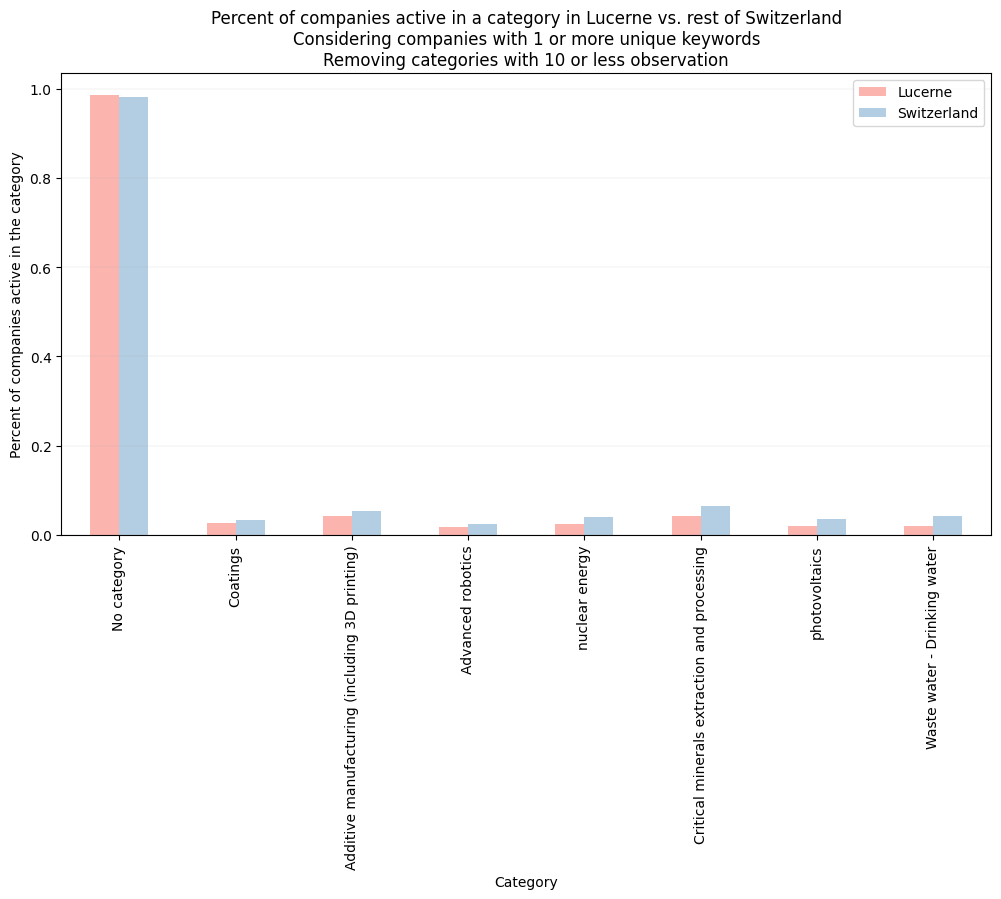

In [8]:
def compare_canton(df: pl.DataFrame, canton: str, thresh: int) -> pl.DataFrame:
    n_canton = df.filter(pl.col("Canton") == canton).select(pl.col("ID").n_unique()).item()
    n_others = df.filter(pl.col("Canton") != canton).select(pl.col("ID").n_unique()).item()
    canton_unique = df.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") == canton
    )
    others_unique = df.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") != canton
    )

    canton_unique = canton_unique.group_by("category").agg(
        pl.len().alias(f"count_{canton}")
    )
    others_unique = others_unique.group_by("category").agg(
        pl.len().alias("count_others")
    )

    plot_data = canton_unique.join(others_unique, on="category")

    # n_canton = plot_data.select(f"count_{canton}").sum().item()
    # n_others = plot_data.select("count_others").sum().item()

    plot_data = (
        plot_data.with_columns(
            (pl.col("count_" + canton) / n_canton).alias(f"percent_{canton}"),
        )
        .with_columns(
            (pl.col("count_others") / n_others).alias("percent_others"),
        )
        .with_columns(
            (pl.col("percent_" + canton) / pl.col("percent_others")).alias("ratio")
        )
        .with_columns(pl.col("ratio").log10().alias("logRTA"))
        .sort("logRTA", descending=True)
    )
    return plot_data

canton = "Lucerne"
thresh = 1
filter_amount = 10

plot_data = compare_canton(patent_unique, canton=canton, thresh=thresh)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

plot_data = plot_data.filter(pl.col(f"count_{canton}") > filter_amount)

cats = plot_data["category"].to_list()
value_canton = plot_data[f"percent_{canton}"].to_list()
value_ch = plot_data[f"percent_others"].to_list()
values = ({canton: value_canton, "Switzerland": value_ch})

cmap = mpl.colormaps["Pastel1"]
colors = cmap([0, 1])

fig, ax = plt.subplots(figsize = (12, 6))
p = plot_data.select("category", f"percent_{canton}", "percent_others").to_pandas().plot.bar(color = colors, ax = ax)

ax.legend([canton, "Switzerland"])
ax.set_ylabel("Percent of companies active in the category")
ax.set_xlabel("Category")
ax.set_xticklabels(cats)
ax.grid(visible=True, alpha = 0.5, which = "major", axis = "y", linewidth = 0.25)
ax.set_title(f"Percent of companies active in a category in {canton} vs. rest of Switzerland\
\nConsidering companies with {thresh} or more unique keywords\
\nRemoving categories with {filter_amount} or less observation")
ax.tick_params(axis="x", labelrotation = 90)

In [9]:
lucerne_patent_1 = compare_canton(patent_unique, canton="Lucerne", thresh=1)
lucerne_patent_3 = compare_canton(patent_unique, canton="Lucerne", thresh=1)
lucerne_web_1 = compare_canton(web_unique, canton="Lucerne", thresh=1)
lucerne_web_3 = compare_canton(web_unique, canton="Lucerne", thresh=1)
plot1 = lucerne_patent_1.join(lucerne_web_1, on = "category", suffix = "_web", how = "inner")
plot3 = lucerne_patent_3.join(lucerne_web_3, on = "category", suffix = "_web", how = "inner")

In [10]:
diff1 = plot1.select("category", "percent_Lucerne", "percent_Lucerne_web")
diff3 = plot3.select("category", "percent_Lucerne", "percent_Lucerne_web")

In [11]:
diff1

category,percent_Lucerne,percent_Lucerne_web
str,f64,f64
"""Directed energy technologies""",0.003205,0.004189
"""Advanced robotics""",0.017628,0.01556
"""supercapacitors""",0.008013,0.008977
"""No category""",0.985577,0.915619
"""Sonar and acoustic sensors""",0.012821,0.00778
…,…,…
"""Satellite positioning and navi…",0.001603,0.002394
"""Quantum sensors""",0.001603,0.000598
"""Genomic sequencing and analysi…",0.00641,0.002992


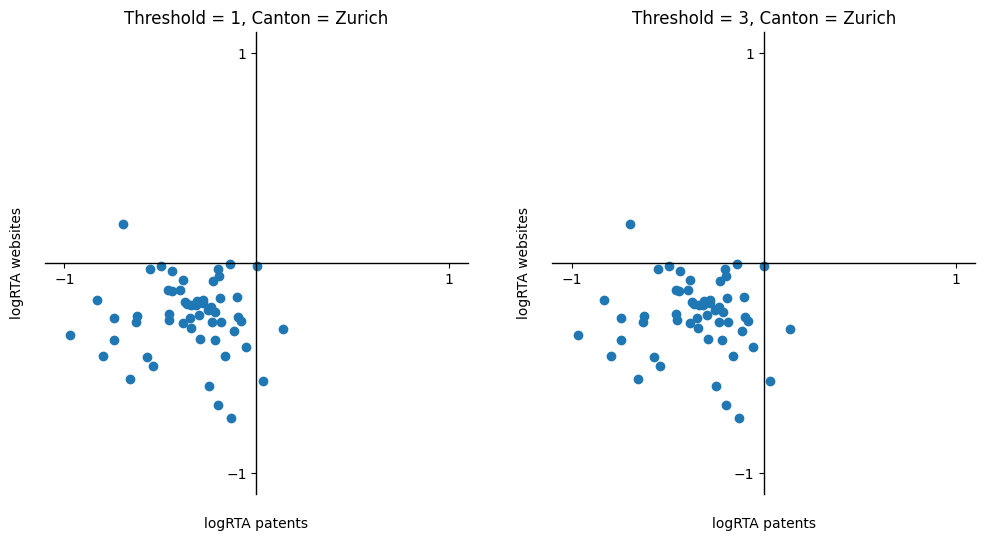

In [12]:
import matplotlib.pyplot as plt
plt.style.use("./style.mplstyle")
fig, ax = plt.subplots(figsize = (12,6), ncols=2, nrows = 1)

ax[0].scatter(data = plot1, x = "logRTA", y = "logRTA_web", label = plot1["category"])
ax[0].set_title("Threshold = 1, Canton = Zurich")

ax[1].scatter(data = plot3, x = "logRTA", y = "logRTA_web", label = plot3["category"])
ax[1].set_title("Threshold = 3, Canton = Zurich")

for a in ax:
    a.set_yticks([-1, 1])
    a.yaxis.set_label_coords(-0.05, 0)
    a.xaxis.set_label_coords(0, -0.05)
    a.set_xticks([-1, 1])

    a.set_ylim(-1.1, 1.1)
    a.set_xlim(-1.1, 1.1)
    a.spines["bottom"].set_position(("data", 0))
    a.spines["left"].set_position(("data", 0))

    a.set_ylabel("logRTA websites")
    a.set_xlabel("logRTA patents")


## Comparing the whole dataset

In [14]:
n_companies_web = web.n_unique("ID")
plot_web = web_unique.filter(pl.col("unique_kw") >= 1).group_by("category").agg(percent_web = pl.len()/n_companies_web)

n_companies_patent = patents.n_unique("ID")
plot_patent = patent_unique.filter(pl.col("unique_kw") >= 1).group_by("category").agg(percent_patent = pl.len()/n_companies_patent)

plot = plot_patent.join(plot_web, on = "category").sort("percent_web", descending=True)

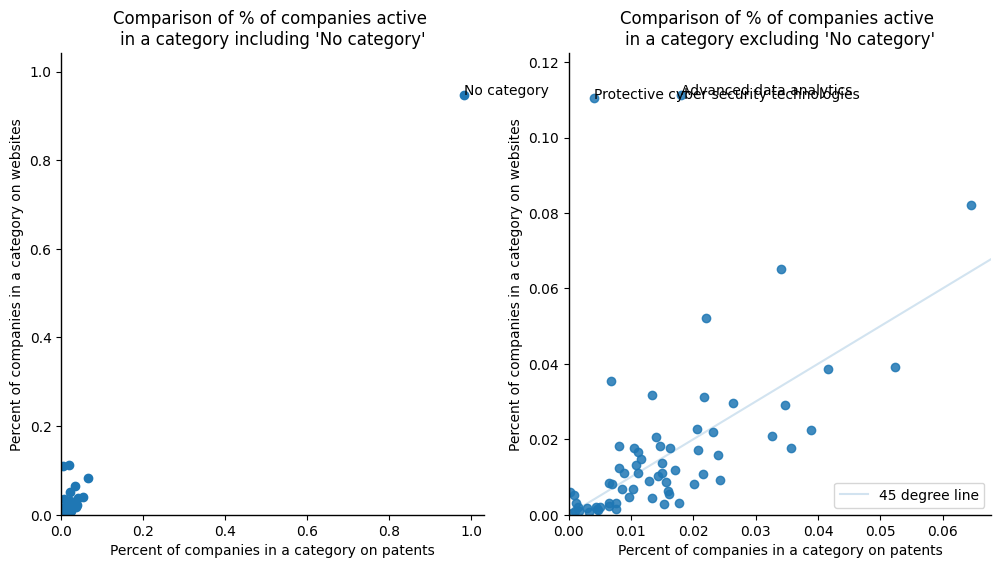

In [40]:
import matplotlib.pyplot as plt
plt.style.use("./style.mplstyle")
fig, ax = plt.subplots(figsize = (12, 6), ncols=2)
ax[0].scatter(data = plot, x = "percent_patent", y = "percent_web")
ax[1].scatter(data = plot[1:], x = "percent_patent", y = "percent_web", label = None, alpha = 0.85)

for a in ax:

    a.set_ylabel("Percent of companies in a category on websites")
    a.set_xlabel("Percent of companies in a category on patents")
    a.set_xlim(0)
    a.set_ylim(0)

ax[0].set_title("Comparison of % of companies active \nin a category including 'No category'")
ax[0].text(plot[0]["percent_patent"].item(), plot[0]["percent_web"].item(), plot[0]["category"].item())

ax[1].set_title("Comparison of % of companies active \nin a category excluding 'No category'")
ax[1].text(plot[1:][0]["percent_patent"].item(), plot[1:][0]["percent_web"].item(), plot[1:][0]["category"].item())
ax[1].text(plot[1:][1]["percent_patent"].item(), plot[1:][1]["percent_web"].item(), plot[1:][1]["category"].item())
ax[1].plot([0,1], [0,1], label = "45 degree line", alpha = 0.2)
ax[1].legend()

In [16]:
pearson = plot[1:].select(pl.corr("percent_patent", "percent_web")).item()
spearman = plot[1:].select(pl.corr("percent_patent", "percent_web", method="spearman")).item()
print(f"Pearson:\t{pearson:.4f}\nspearman:\t{spearman:.4f}")

Pearson:	0.4748
spearman:	0.6929


In [17]:
rank_web = plot_web.sort("percent_web",descending=True).with_columns(rank_web = pl.col("percent_web").rank("ordinal", descending=True))
rank_patent= plot_patent.sort("percent_patent",descending=True).with_columns(rank_patent = pl.col("percent_patent").rank("ordinal", descending=True))

rank_plot = rank_web.join(rank_patent, on = "category").select("rank_web", "rank_patent", "category")

Text(0.5, 1.0, 'Scatterplot of the rank of categories on websites vs patents\ni.e. Rank = 1 means highest occuring category')

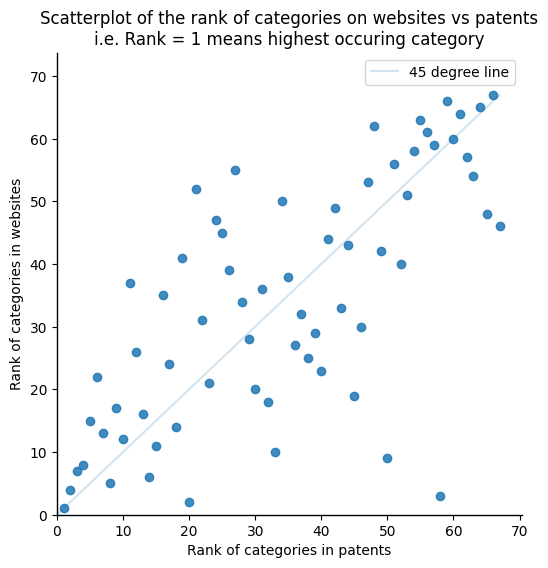

In [18]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(data = rank_plot, x = "rank_patent", y = "rank_web", label = None, alpha = 0.85)
ax.set_xlabel("Rank of categories in patents")
ax.set_ylabel("Rank of categories in websites")
ax.plot([0,67], [0,67], alpha = 0.2, label="45 degree line")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_title("Scatterplot of the rank of categories on websites vs patents\n" \
"i.e. Rank = 1 means highest occuring category")

In [19]:
pearson = rank_plot[1:].select(pl.corr("rank_patent", "rank_web")).item()
spearman = rank_plot[1:].select(pl.corr("rank_patent", "rank_web", method="spearman")).item()
print(f"Pearson:\t{pearson:.4f}\nspearman:\t{spearman:.4f}")

Pearson:	0.6931
spearman:	0.6931


In [20]:
rank_plot[1:].with_columns(
    difference = (pl.col("rank_patent").cast(pl.Int64) - pl.col("rank_web").cast(pl.Int64)).abs()
).sort("difference", descending=True).head(10)

rank_web,rank_patent,category,difference
u32,u32,str,i64
3,58,"""Protective cyber security tech…",55
9,50,"""Natural language processing (i…",41
52,21,"""Air independent propulsion""",31
55,27,"""Directed energy technologies""",28
37,11,"""supercapacitors""",26
19,45,"""High-specification machining p…",26
47,24,"""Smart materials""",23
10,33,"""Autonomous systems operation t…",23
41,19,"""Sonar and acoustic sensors""",22


### Trying to clean this up

In [21]:
plot.with_columns(
    difference = (pl.col("percent_patent") - pl.col("percent_web")).abs()
).sort("difference", descending=True).head(10)

category,percent_patent,percent_web,difference
str,f64,f64,f64
"""Protective cyber security tech…",0.004125,0.110365,0.10624
"""Advanced data analytics""",0.017988,0.111407,0.093419
"""No category""",0.982215,0.947696,0.034519
"""Machine learning (including ne…",0.034149,0.065133,0.030984
"""Distributed ledgers""",0.021977,0.05203,0.030053
"""Natural language processing (i…",0.00683,0.03539,0.02856
"""Autonomous systems operation t…",0.013457,0.031717,0.01826
"""photovoltaics""",0.035705,0.017654,0.018051
"""Critical minerals extraction a…",0.064579,0.082102,0.017523


In [22]:
cat = "Advanced data analytics"
words_web = web.filter(pl.col("category")==cat).group_by("keyword").agg(pl.len()).sort("len", descending=True)
words_patents = patents.filter(pl.col("category")==cat).group_by("keyword").agg(pl.len()).sort("len", descending=True)

words_comparison = words_web.join(words_patents, on = "keyword", how = "full", suffix = "_patent").with_columns(pl.col("len", "len_patent").fill_null(0))

In [23]:
words_comparison.with_columns(diff = (pl.col("len").cast(pl.Int128) - pl.col("len_patent").cast(pl.Int128)).abs()).sort("diff", descending=True).head(10)

keyword,len,keyword_patent,len_patent,diff
str,u32,str,u32,i128
"""optimisation du portefeuille""",21617,null,0,21617
"""business intelligence""",10948,null,0,10948
"""kubernetes""",8988,null,0,8988
"""web analytics""",5551,null,0,5551
"""digital twin""",4258,"""digital twin""",263,3995
"""power bi""",3836,null,0,3836
"""data quality""",3418,"""data quality""",29,3389
"""data lake""",2957,"""data lake""",3,2954
"""ruche""",2866,"""ruche""",4,2862


In [24]:
n_patents = patents.select(pl.len()).item()
n_pages = web.select(pl.len()).item()
wf_patents = patents.unique(["keyword", "Publication number"]).group_by("keyword").agg(pl.len()/n_patents)
wf_web = web.unique(["keyword", "url"]).group_by("keyword").agg(pl.len()/n_pages)


In [25]:
wf_comparison = wf_patents.join(wf_web, on = "keyword", suffix="_web", how = "full").with_columns(pl.col("len", "len_web").fill_null(0))
wf_comparison = wf_comparison.with_columns(difference = (pl.col("len") - pl.col("len_web")).abs()).sort("difference", descending=True)\
.join(lookup, on="keyword")

In [44]:
wf_comparison.with_columns(pl.col("difference")*1000).filter(pl.col("category").str.starts_with("Protective")).sort("difference", descending=True).head(10)

keyword,len,keyword_web,len_web,difference,category
str,f64,str,f64,f64,str
"""conditional access""",0.000195,"""conditional access""",0.000023,0.172422,"""Protective cyber security tech…"
"""aes-256""",4.4746e-7,"""aes-256""",0.00017,0.169495,"""Protective cyber security tech…"
"""identity and access management""",0.000003,"""identity and access management""",0.000046,0.043223,"""Protective cyber security tech…"
"""tokenization""",0.000005,"""tokenization""",0.000042,0.036261,"""Protective cyber security tech…"
"""single sign-on""",0.000009,"""single sign-on""",0.000042,0.032947,"""Protective cyber security tech…"
"""key management""",0.000016,"""key management""",0.000047,0.031082,"""Protective cyber security tech…"
"""transport layer security""",8.9491e-7,"""transport layer security""",0.00003,0.029472,"""Protective cyber security tech…"
"""data loss prevention""",0.000003,"""data loss prevention""",0.000029,0.026095,"""Protective cyber security tech…"
"""homomorphic encryption""",0.000017,"""homomorphic encryption""",0.000001,0.015273,"""Protective cyber security tech…"


In [217]:
pl.read_parquet(DATA_DIR + "processed/aspi_categories.parquet").select("description").write_csv("aspi_descriptions.csv")